In [301]:
import torch
import re
import json
import pandas as pd
import random
import time
import math
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
from itertools import combinations
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import roc_curve, auc
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [302]:
path = '/home/user/Videos/inference/feature_split/chng.xlsx'
formulas = pd.read_excel(path) 

In [303]:
formulas.columns

Index(['avg', 'rel_count', 'qnt_count_tenprcnt', 'no_of_sentence_have_quant',
       'temporal_sim_qs', 'trust_temporal', 'count_presence', 'count_agree',
       'temporal_agree', 'llm_dec', 'titles', 'trust', 'label'],
      dtype='object')

In [304]:
llm = ['llm_dec','titles','trust']
temporal = ['temporal_sim_qs','trust_temporal','temporal_agree']
quant = ['qnt_count_tenprcnt','no_of_sentence_have_quant','count_agree']
semantic = ['avg','rel_count']

In [305]:
lists = [semantic, quant, temporal, llm]

# Generate all possible pairs
pairs = list(combinations(lists, 3))

In [306]:
len(pairs)

4

In [307]:
t = 3

In [308]:
pairs[t]

(['qnt_count_tenprcnt', 'no_of_sentence_have_quant', 'count_agree'],
 ['temporal_sim_qs', 'trust_temporal', 'temporal_agree'],
 ['llm_dec', 'titles', 'trust'])

In [309]:
pairs[t][0]

['qnt_count_tenprcnt', 'no_of_sentence_have_quant', 'count_agree']

In [310]:
pairs[t][1]

['temporal_sim_qs', 'trust_temporal', 'temporal_agree']

In [311]:
pairs[t][2]

['llm_dec', 'titles', 'trust']

In [312]:
data = formulas[pairs[t][0]+pairs[t][1]+pairs[t][2]+['label']]

In [313]:
# Combination - quant + LLM + temporal

In [314]:
data.head()

,qnt_count_tenprcnt,no_of_sentence_have_quant,count_agree,temporal_sim_qs,trust_temporal,temporal_agree,llm_dec,titles,trust,label
0,6,6,10,6,0.545455,6,1,0.571429,0.5,1
1,6,6,10,6,0.545455,6,1,0.571429,0.5,1
2,1,1,1,1,0.500000,1,1,1.000000,1.0,1
3,2,2,2,1,0.500000,1,1,1.000000,1.0,1
4,2,2,2,2,0.000000,2,1,0.000000,0.0,1


In [315]:
data.shape

(1665, 10)

In [316]:
result = data

In [317]:
y = result['label']
X = result.drop(['label'],axis=1)

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [319]:
X_train.shape

(1498, 9)

In [320]:
X_train = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.values.reshape(-1, 1) if isinstance(y_train, pd.Series) else y_train
X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
y_test = y_test.values.reshape(-1, 1) if isinstance(y_test, pd.Series) else y_test

In [321]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [322]:
test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [323]:
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [324]:
X_train.shape[1]

9

In [325]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Define image classification layers
        self.image_classification_layer = nn.Sequential(
            nn.Linear(X_train.shape[1], 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(512, 512)
        )

        # Define final classification layer
        self.final_classification_layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.50),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image tensor
        image_embedding = self.image_classification_layer(x)
        z = torch.cat([image_embedding], 1)
        return torch.sigmoid(self.final_classification_layer(z))

In [326]:
model = NeuralNetwork()
criteria = nn.BCELoss()  # Assuming binary classification
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [327]:
epochs = 100

In [328]:
losses = []

In [329]:
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X)

        # Compute the loss
        batch_y = batch_y.view(-1, 1)
        loss = criteria(outputs, batch_y.float())  # Assuming binary classification

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss or other metrics if desired
        # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
    losses.append(loss.item())
    
    model.eval()  # Set model to evaluation mode
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for test_X, test_y in test_loader:
            outputs = model(test_X)
            test_y = test_y.view(-1, 1)

            # Compute test loss
            loss = criteria(outputs, test_y.float())
            test_loss += loss.item()

            # Binary classification: convert outputs to predicted labels
            predicted = (outputs >= 0.5).float()  # Assuming threshold of 0.5 for binary
            correct += (predicted == test_y).sum().item()
            total += test_y.size(0)

    # Calculate average test loss and accuracy for the epoch
    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/100, Test Loss: 0.4101, Accuracy: 89.22%
Epoch 2/100, Test Loss: 0.4099, Accuracy: 89.22%
Epoch 3/100, Test Loss: 0.3354, Accuracy: 90.42%
Epoch 4/100, Test Loss: 0.3456, Accuracy: 89.82%
Epoch 5/100, Test Loss: 0.3285, Accuracy: 91.02%
Epoch 6/100, Test Loss: 0.3504, Accuracy: 89.82%
Epoch 7/100, Test Loss: 0.4296, Accuracy: 89.22%
Epoch 8/100, Test Loss: 0.3451, Accuracy: 89.82%
Epoch 9/100, Test Loss: 0.3306, Accuracy: 89.22%
Epoch 10/100, Test Loss: 0.3286, Accuracy: 90.42%
Epoch 11/100, Test Loss: 0.3686, Accuracy: 87.43%
Epoch 12/100, Test Loss: 0.4614, Accuracy: 89.82%
Epoch 13/100, Test Loss: 0.3781, Accuracy: 90.42%
Epoch 14/100, Test Loss: 0.4003, Accuracy: 89.82%
Epoch 15/100, Test Loss: 0.4799, Accuracy: 90.42%
Epoch 16/100, Test Loss: 0.3315, Accuracy: 91.02%
Epoch 17/100, Test Loss: 0.3494, Accuracy: 90.42%
Epoch 18/100, Test Loss: 0.3180, Accuracy: 91.02%
Epoch 19/100, Test Loss: 0.3089, Accuracy: 91.62%
Epoch 20/100, Test Loss: 0.3402, Accuracy: 91.62%
Epoch 21/

In [330]:
model.eval()

NeuralNetwork(
  (image_classification_layer): Sequential(
    (0): Linear(in_features=9, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=512, bias=True)
  )
  (final_classification_layer): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [331]:
def plot_auroc(y_true, y_scores):
    """
    Plots the AUROC curve for given true labels and predicted scores.
    
    Parameters:
    - y_true: Ground truth binary labels (0 or 1) as a tensor or array
    - y_scores: Predicted scores from the model (raw output probabilities or logits)
    """
    # Convert tensors to numpy arrays if needed
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().numpy()
    if isinstance(y_scores, torch.Tensor):
        y_scores = y_scores.cpu().numpy()
    
    # Compute FPR, TPR, and AUROC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    
    # Plotting AUROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

In [332]:
with torch.no_grad():
    y_scores = model(X_test_tensor).squeeze()  # Assuming output shape matches y_test_tensor

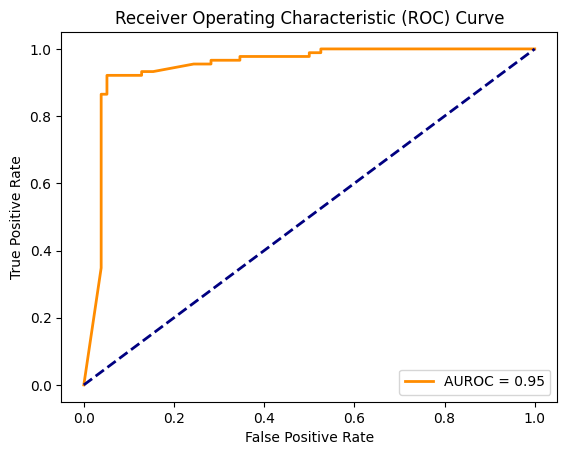

AUC Score: 0.95


In [333]:
fpr, tpr, roc_auc = plot_auroc(y_test_tensor, y_scores)
print(f"AUC Score: {roc_auc:.2f}")

In [334]:
with torch.no_grad():
    y_scores = model(X_test_tensor).numpy()  # Assuming output shape matches y_test_tensor

In [335]:
threshold = 0.5
y_pred_custom = (y_scores >= threshold).astype(int)

In [336]:
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)
f1 = f1_score(y_test, y_pred_custom)

In [337]:
print(f'Precision (threshold={threshold}): {precision:.2f}')
print(f'Recall (threshold={threshold}): {recall:.2f}')
print(f'F1 Score (threshold={threshold}): {f1:.2f}')

Precision (threshold=0.5): 0.95
Recall (threshold=0.5): 0.88
F1 Score (threshold=0.5): 0.91


In [338]:
# Combination - quant + LLM + temporal